# TP3: Técnicas de Machine Learning para clasificar datos de EEG

<p style="text-align: justify;">
En el marco de la materia optativa *Ciencia de Datos* estudiamos técnicas de Machine Learning aplicadas a datos adquiridos mediante electroencefalografía (EEG). En la [página web de la materia](http://www.dc.uba.ar/materias/cienciadatos) se encuentran disponibles los [datos](http://calamaro.exp.dc.uba.ar/~fraimondo/cienciadatos/data/) utilizados, así como también las [referencias teóricas](http://www.dc.uba.ar/materias/cienciadatos/teoricas) y la [guía](https://gist.github.com/fraimondo/9f779d083a47c18800130ca8d1b143b9) para el desarrollo de los análisis correspondientes. <br>

<p style="text-align: justify;">
En el presente trabajo aplicamos técnicas de Machine Learning univariadas (una variable/feature) y multivariadas (mutiples variabes/features) para entrenar clasificadores que permitan discriminar grupos de datos de EEG a partir de ciertos atributos o *features*. Obtuvimos la curva ROC de cada feature por separado y su correspondiente AUC, para estudiar la capacidad de discriminación de ese feature con respecto a la pertenencia al grupo S o P. Para cada feature entrenamos un clasificador binario mediante el algoritmo de Logistic Regression y evaluamos su capacidad de clasificación. Luego realizamos un análisis multivariado, utilizando todas las features para entrenar un clasificador binario usando Support Vector Machines (SVM). Exploramos distintas herramientas para mejorar el aprendizaje supervisado y las formas de entrenamiento del clasificador. 
</p> 

## Tabla de Contenidos 

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [1. Datos](#datos)
    - [1.1. Features](#features)  
    - [1.2. Paquetes](#paquetes)  
- [2. Machine Learning](#ml)
    - [2.1. Análisis Univariado](#univariado)
        - [2.1.a. Curva ROC para cada feature](#roc)
        - [2.1.b. Logistic Regression](#lr)
    - [2.2. Análisis Multivariado](#multivariado)
<!-- /MarkdownTOC -->

<a name="datos"></a>
## 1. Datos

<p style="text-align: justify;">
La técnica de electroencefalografía (EEG) consiste en medir la actividad eléctrica del cerebro. Para su medición, se utilizan electrodos (sensores) que se ubican en el cuero cabelludo. Cada electrodo mide en forma independiente las fluctuaciones de voltaje, generando una señal analógica que es amplificada y luego digitalizada. Los sistemas de EEG suelen variar en cantidad y ubicación de los electrodos, y en la frecuencia de muestreo. Los datos utilizados en este trabajo provienen de un sistema de EEG con 256 electrodos de solucion salina digitalizados a 250 Hz. Los mismos corresponden a una evaluación cognitiva realizada a 20 sujetos, de los cuales el 50% posee capacidades cognitivas normales (Grupo S), mientras que los resultados para el 50% restante determinaron que poseen capacidades cognitivas severamente disminuidas (Grupo P). Cada evaluación dura aproximadamente 30 minutos, en los cuales son estimulados auditivamente aproximadamente unas 1200 veces.
</p> 

<a name="features"></a>
## 1.1. Features

<p style="text-align: justify;">
En el presente trabajo se utilizan técnicas de _machine learning_ univariadas y multivariadas con el objetivo de clasificar los sujetos de los grupos S y P estudiados previamente en el trabajo anterior. A partir de los análisis realizados anteriormente, elegimos ciertos atributos o propiedades de las series temporales adquiridas mediante EEG. Los features se definen y calculan en un [notebook aparte](https://github.com/m2march/ciencia_datos/blob/master/tp3/Feature%20Processing.ipynb). Los features utilizados son:
    <li> Potencia de bandas espectrales. </li>
    <li> Potencia de bandas espectrales normalizadas. </li>
    <li> Entropía intra-electrodos. </li>
    <li> Entropía inter-electrodos. </li>
Para cada una de ellas se calculó su promedio (entre trials) y desvío standard obteniéndose así 24 features en total. Las mismas fueron guardadas en la carpeta [pickles](https://github.com/m2march/ciencia_datos/tree/master/tp3/pickles).
</p> 

<a name="paquetes"></a>
## 1.2. Paquetes

<p style="text-align: justify;">
Cargamos los paquetes de Python necesarios para el análisis.
</p> 

In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [3]:
import pickle
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import svm
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn import pipeline
from sklearn import feature_selection
from sklearn import model_selection 
from sklearn import naive_bayes

<a name="ml"></a>
## 2. Machine Learning

<a name="univariado"></a>
## 2.1. Análisis Univariado

<p style="text-align: justify;">
Estudiamos la capacidad de discriminación entre clases de cada feature y entrenamos clasificadores utilizando su información  por separado mediante el algoritmo de Logistic Regression.
</p> 

<a name="roc"></a>
## 2.1.a. Curva ROC para cada feature

<p style="text-align: justify;">
La curva ROC (_receiver operating characteristic_) es un gráfico que muestra la habilidad de un clasificador binario. Básicamente es la relación entre la proporción de los verdaderos positivos y de los falsos positivos. Para cuantificar esta magnitud se utiliza el área bajo la curva (AUC). Como parte del análisis univariado, obtuvimos la curva ROC para cada feature.
</p> 

In [4]:
def roc_univariado(valores, etiquetas, etiqueta_true):
    """
    Args:
        valores valores del feature de interes
        etiquetas etiquetas para cada valor
        etiqueta_true etiqueta a la que corresponde cuando el valor es mayor al umbral
        
    Returns:
        umbrales
        tprs
        fprs
        area bajo la curva roc
        tnrs
    """
    m = min(valores)
    M = max(valores) 
    n = 100
    xs = np.linspace(m, M * 1.01, n)
    tprs = []
    fprs = []
    tnrs = []
    for idx in range(n):
        ts = np.array((valores >= xs[idx]).values)
        
        tp = np.sum(etiquetas[ts] == etiqueta_true)
        fp = np.sum(etiquetas[ts] != etiqueta_true)
        tn = np.sum(etiquetas[np.invert(ts)] != etiqueta_true)
        fn = np.sum(etiquetas[np.invert(ts)] == etiqueta_true)
        
        tpr = tp / (tp + fn) #sensitivity
        fpr = fp / (fp + tn)
        tnr = tn / (tn + fp) #specificity
        
        tprs.append(tpr)
        fprs.append(fpr)
        tnrs.append(tnr)
        
    tprs = np.array(tprs)
    fprs = np.array(fprs)
    tnrs = np.array(tnrs)

    aroc = metrics.roc_auc_score([c == etiqueta_true for c in etiquetas], valores)
        
    return (xs, tprs, fprs, aroc, tnrs)

In [5]:
def plot_rocs(ax, _title, args):
    """
    Grafica las curvas roc.
    
    Args:
        args: lista de (nombre, fprs, tprs, auc)
    """
    sca(ax)
    for nombre, fprs, tprs, auc in args:
        plot(fprs, tprs, lw=2, alpha=0.5, label='{} AUC = {:.2f}'.format(nombre, auc))
        
    plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    xlabel('True Positive Rate')
    ylabel('False Positive Rate')
    legend(loc='lower right')
    title(_title)

In [6]:
etiquetas = np.array(['P'] * 10 + ['S'] * 10)

Se cargan los valores de todos los atributos:

In [7]:
band_mean = pd.read_pickle('pickles/band_power_mean.pkl')
band_std = pd.read_pickle('pickles/band_power_std.pkl')
band_norm_mean = pd.read_pickle('pickles/band_power_norm_mean.pkl')
band_norm_std = pd.read_pickle('pickles/band_power_norm_std.pkl')
intra_entropy = pd.read_pickle('pickles/intra_entropy.pkl')
inter_entropy = pd.read_pickle('pickles/inter_entropy.pkl')

A modo de ejemplo y para clarificar el comportamiento de una curva ROC, se grafica a continuación únicamente las curvas correspondientes al promedio entre trials de las potencias de bandas espectrales.

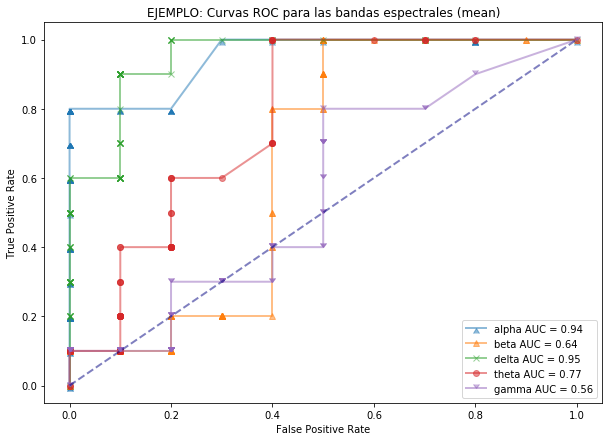

In [7]:
xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_mean['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_mean['beta'], etiquetas, 'S')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_mean['delta'], etiquetas, 'P')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_mean['theta'], etiquetas, 'P')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_mean['gamma'], etiquetas, 'S')

plt.figure(figsize=(10, 7))
plot(fprs_a, tprs_a, lw=2, marker=6, alpha=0.5, label='alpha AUC = {:.2f}'.format(aroc_a))
plot(fprs_b, tprs_b, lw=2, marker='^', alpha=0.5, label='beta AUC = {:.2f}'.format(aroc_b))
plot(fprs_d, tprs_d, lw=2, marker='x', alpha=0.5, label='delta AUC = {:.2f}'.format(aroc_d))
plot(fprs_t, tprs_t, lw=2, marker='o', alpha=0.5, label='theta AUC = {:.2f}'.format(aroc_t))
plot(fprs_g, tprs_g, lw=2, marker=7, alpha=0.5, label='gamma AUC = {:.2f}'.format(aroc_g))
plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
xlabel('False Positive Rate')
ylabel('True Positive Rate')
legend(loc='lower right')
title('EJEMPLO: Curvas ROC para las bandas espectrales (mean)')
plt.show()

En el gráfico se observa que, dentro de esta categoría de atributos, la banda espectral delta es la que mejor clasifica los sujetos con un AUC de 0.95. La banda alpha muestra una capacidad de discriminación de clases significativamente mayor a la chance con un AUC de 0.94. La banda gamma presenta una precisión baja, resultando su AUC muy cercana a la del azar. Por último las bandas beta y theta tienen un comportamiento regular respecto a la clasificación.

A continuación se prosigue de modo similar y se presentan todas las curvas ROCs:

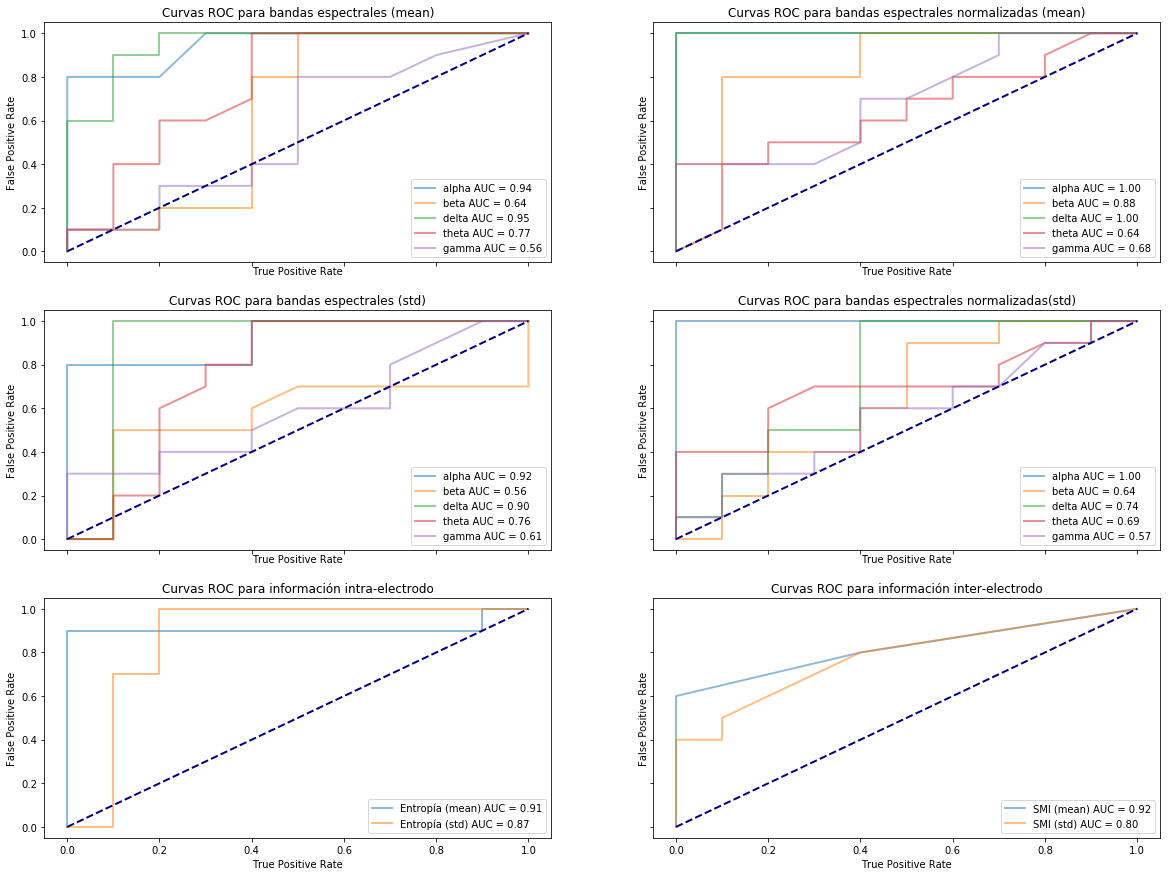

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15), sharex=True, sharey=True)
#bandas espectrales (mean)
xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_mean['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_mean['beta'], etiquetas, 'S')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_mean['delta'], etiquetas, 'P')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_mean['theta'], etiquetas, 'P')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_mean['gamma'], etiquetas, 'S')
plot_rocs(axs[0][0], 'Curvas ROC para bandas espectrales (mean)',
         [('alpha', fprs_a, tprs_a, aroc_a),
          ('beta', fprs_b, tprs_b, aroc_b),
          ('delta', fprs_d, tprs_d, aroc_d),
          ('theta', fprs_t, tprs_t, aroc_t),
          ('gamma', fprs_g, tprs_g, aroc_g),
         ])

#bandas espectrales normalizadas (mean)
xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_norm_mean['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_norm_mean['beta'], etiquetas, 'S')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_norm_mean['delta'], etiquetas, 'P')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_norm_mean['theta'], etiquetas, 'P')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_norm_mean['gamma'], etiquetas, 'S')
plot_rocs(axs[0][1], 'Curvas ROC para bandas espectrales normalizadas (mean)',
         [('alpha', fprs_a, tprs_a, aroc_a),
          ('beta', fprs_b, tprs_b, aroc_b),
          ('delta', fprs_d, tprs_d, aroc_d),
          ('theta', fprs_t, tprs_t, aroc_t),
          ('gamma', fprs_g, tprs_g, aroc_g),
         ])

#bandas espectrales (std)
xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_std['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_std['beta'], etiquetas, 'P')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_std['delta'], etiquetas, 'P')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_std['theta'], etiquetas, 'P')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_std['gamma'], etiquetas, 'P')
plot_rocs(axs[1][0], 'Curvas ROC para bandas espectrales (std)',
         [('alpha', fprs_a, tprs_a, aroc_a),
          ('beta', fprs_b, tprs_b, aroc_b),
          ('delta', fprs_d, tprs_d, aroc_d),
          ('theta', fprs_t, tprs_t, aroc_t),
          ('gamma', fprs_g, tprs_g, aroc_g),
         ])

#bandas espectrales normalizadas (std)
xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_norm_std['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_norm_std['beta'], etiquetas, 'S')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_norm_std['delta'], etiquetas, 'S')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_norm_std['theta'], etiquetas, 'P')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_norm_std['gamma'], etiquetas, 'S')
plot_rocs(axs[1][1], 'Curvas ROC para bandas espectrales normalizadas(std)',
         [('alpha', fprs_a, tprs_a, aroc_a),
          ('beta', fprs_b, tprs_b, aroc_b),
          ('delta', fprs_d, tprs_d, aroc_d),
          ('theta', fprs_t, tprs_t, aroc_t),
          ('gamma', fprs_g, tprs_g, aroc_g),
         ])

#entropia intra-electrodo (mean y std)
xs_intra_mean, tprs_intra_mean, fprs_intra_mean, aroc_intra_mean, tnrs_intra_mean = roc_univariado(intra_entropy['mean'], etiquetas, 'S')
xs_intra_std, tprs_intra_std, fprs_intra_std, aroc_intra_std, tnrs_intra_std = roc_univariado(intra_entropy['std'], etiquetas, 'P')
plot_rocs(axs[2][0], 'Curvas ROC para información intra-electrodo',
         [('Entropía (mean)', fprs_intra_mean, tprs_intra_mean, aroc_intra_mean),
          ('Entropía (std)', fprs_intra_std, tprs_intra_std, aroc_intra_std),
         ])

#entropia inter-electrodo (mean y std)
xs_inter_mean, tprs_inter_mean, fprs_inter_mean, aroc_inter_mean, tnrs_inter_mean = roc_univariado(inter_entropy['mean'], etiquetas, 'S')
xs_inter_std, tprs_inter_std, fprs_inter_std, aroc_inter_std, tnrs_inter_std = roc_univariado(inter_entropy['std'], etiquetas, 'S')
plot_rocs(axs[2][1], 'Curvas ROC para información inter-electrodo',
         [('SMI (mean)', fprs_inter_mean, tprs_inter_mean, aroc_inter_mean),
          ('SMI (std)', fprs_inter_std, tprs_inter_std, aroc_inter_std),
         ])

<p style="text-align: justify;">
En los paneles se presentan las curvas ROC obtenidas para cada feature, agrupadas en categorías. En el caso del primer panel (promedio de bandas espectrales) y como ya fue mencionado anteriormente, la banda gamma tiene un desempeño similar al del azar (AUC = 0.56) el cual mejora un 46% al normalizar su potencia espectral (AUC = 0.82). También se observa una notable mejoría en la banda espectral alpha al normalizar alcanzando un AUC = 1.00, en la banda beta (AUC = 0.99), y para el caso de la banda delta (AUC = 0.98). Únicamente la banda theta mostró un desempeño peor para la clasificación en el caso de la normalización.
<br>
Respecto a los desvíos standard, para las bandas no normalizadas, se encuentra que estos atributos no son mejores que sus promedios excepto para la banda gamma. Es decir, para esta banda, su fluctación tiene mayor capacidad de discriminación de clases de sujetos que sus potencia media. A pesar de esto, sólo alcanza un AUC de 0.61.
<br>
En general, se observa que las bandas con mayor capacidad de clasificación son las bandas alpha y delta. Para estas bandas, los valores de AUCs resultan respectivamente 0.94 y 0.95 para la potencia promedio no normalizada, 1.00 y 1.00 para la potencia promedio normalizada, 0.92 y 0.90 para la desviación standard de la potencia no normalizada, y 1.00 y 0.74 para la desviación standard de la potencia normalizada. Estos valores de AUCs son significativamente mayores a los obtenidos por azar, lo que indicaría que estos atributos podrían ser más útiles que otros para la clasificación.
<br>
Por último se comparan las curvas obtenidas para las medidas de información intra e inter electrodos. En ambos casos el promedio de estas magnitudes alcanza un AUC de 0.91 y 0.92 respectivamente mientras que para los desvíos standard la entropía intra-electrodos tiene AUC = 0.87 y entropía inter-electrodo de 0.80.
</p> 

<p style="text-align: justify;">
A continuación se resumen en la siguiente tabla los features que mejor precisión han alcanzado (AUC $>=$ 0.90) durante el análisis univariado estudiado mediante las correspondientes curvas ROC y sus AUCs.
</p> 

In [9]:
aucs = pd.DataFrame({
    'AUC':{
        'alpha (mean)': 0.94,
        'alpha norm (mean)': 1.00,
        'alpha (std)': 0.92,
        'alpha norm (std)': 1.00,
        'delta (mean)': 0.95,
        'delta (std)': 0.90,
        'beta norm (mean)': 0.99,
        'delta norm (mean)': 0.98,
        'beta norm (std)': 0.97,
        'H (mean)' : 0.90,
        'SMI (mean)': 0.92
    }
})
aucs.sort_values('AUC', ascending=False)

,AUC
alpha norm (mean),1.00
alpha norm (std),1.00
beta norm (mean),0.99
delta norm (mean),0.98
beta norm (std),0.97
delta (mean),0.95
alpha (mean),0.94
SMI (mean),0.92
alpha (std),0.92
H (mean),0.90


<a name="lr"></a>
## 2.1.b. Logistic Regression

In [8]:
etiquetas_binarias = [c == 'P' for c in etiquetas]

<p style="text-align: justify;">
En este caso se quiere hacer nuevamente un análisis univariado pero mediante regresión logística utilizando una técnica de _cross validation_. A modo de ejemplo se presenta el análisis para el promedio de las bandas espectrales normalizadas y luego se aplica al resto de las features. Se presentan también las curvas ROC.
</p> 

In [9]:
y=etiquetas_binarias
lr_cv = linear_model.LogisticRegressionCV(scoring='accuracy',cv=10)
#X_i --> se cargan los promedios de las bandas espectrales normalizadas

X_a=band_norm_mean['alpha'].values.reshape(-1, 1)
lr_cv_a = lr_cv.fit(X_a, y)
y_score_a = lr_cv_a.decision_function(X_a)

X_b=band_norm_mean['beta'].values.reshape(-1, 1)
lr_cv_b = lr_cv.fit(X_b, y)
y_score_b = lr_cv_b.decision_function(X_b)

X_d=band_norm_mean['delta'].values.reshape(-1, 1)
lr_cv_d = lr_cv.fit(X_d, y)
y_score_d = lr_cv_d.decision_function(X_d)

X_t=band_norm_mean['theta'].values.reshape(-1, 1)
lr_cv_t = lr_cv.fit(X_t, y)
y_score_t = lr_cv_t.decision_function(X_t)

X_g=band_norm_mean['gamma'].values.reshape(-1, 1)
lr_cv_g = lr_cv.fit(X_g, y)
y_score_g = lr_cv_g.decision_function(X_g)

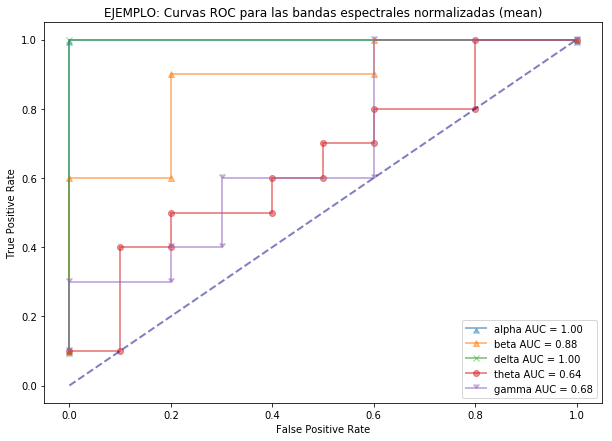

In [10]:
fpr_a, tpr_a, trs_a = metrics.roc_curve(y, y_score_a)
auc_a = metrics.roc_auc_score(y, y_score_a)
fpr_b, tpr_b, trs_b = metrics.roc_curve(y, y_score_b)
auc_b = metrics.roc_auc_score(y, y_score_b)
fpr_d, tpr_d, trs_d = metrics.roc_curve(y, y_score_d)
auc_d = metrics.roc_auc_score(y, y_score_d)
fpr_t, tpr_t, trs_t = metrics.roc_curve(y, y_score_t)
auc_t = metrics.roc_auc_score(y, y_score_t)
fpr_g, tpr_g, trs_g = metrics.roc_curve(y, y_score_g)
auc_g = metrics.roc_auc_score(y, y_score_g)


plt.figure(figsize=(10, 7))
plot(fpr_a, tpr_a, lw=2, marker=6, alpha=0.5, label='alpha AUC = {:.2f}'.format(auc_a))
plot(fpr_b, tpr_b, lw=2, marker='^', alpha=0.5, label='beta AUC = {:.2f}'.format(auc_b))
plot(fpr_d, tpr_d, lw=2, marker='x', alpha=0.5, label='delta AUC = {:.2f}'.format(auc_d))
plot(fpr_t, tpr_t, lw=2, marker='o', alpha=0.5, label='theta AUC = {:.2f}'.format(auc_t))
plot(fpr_g, tpr_g, lw=2, marker=7, alpha=0.5, label='gamma AUC = {:.2f}'.format(auc_g))
plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
xlabel('False Positive Rate')
ylabel('True Positive Rate')
title('EJEMPLO: Curvas ROC para las bandas espectrales normalizadas (mean)')
legend(loc='lower right')
plt.show()

<p style="text-align: justify;">
Para el caso de un clasificador de Regresión Logística (RL) utilizando una técnica de cross-validation aplicado al promedio de las bandas espectrales normalizadas, se encuentra el mismo comportamiento que en el análisis anterior alcanzando las bandas alpha y delta una AUC de 1, es decir, vuelven a ser clasificadores perfectos.
</p> 

In [11]:
def plot_roc_logisticCV(ax, _title, args):
    """
    Calcula la regresion logística con cross validation y plotea las rocs
    
    Args:
        args: lista (nombre, valores)
    """
    args_roc = []
    for nombre, values in args:
        lr_cv = linear_model.LogisticRegressionCV(scoring='accuracy',cv=10)
        r_values = values.reshape(-1, 1)
        lr_cv.fit(X=r_values, y=etiquetas_binarias)
        y_score = lr_cv.decision_function(r_values)
        fpr, tpr, trs = metrics.roc_curve(etiquetas_binarias, y_score)
        auc = metrics.roc_auc_score(etiquetas_binarias, y_score)
        args_roc.append((nombre, fpr, tpr, auc))

    plot_rocs(ax, _title, args_roc)

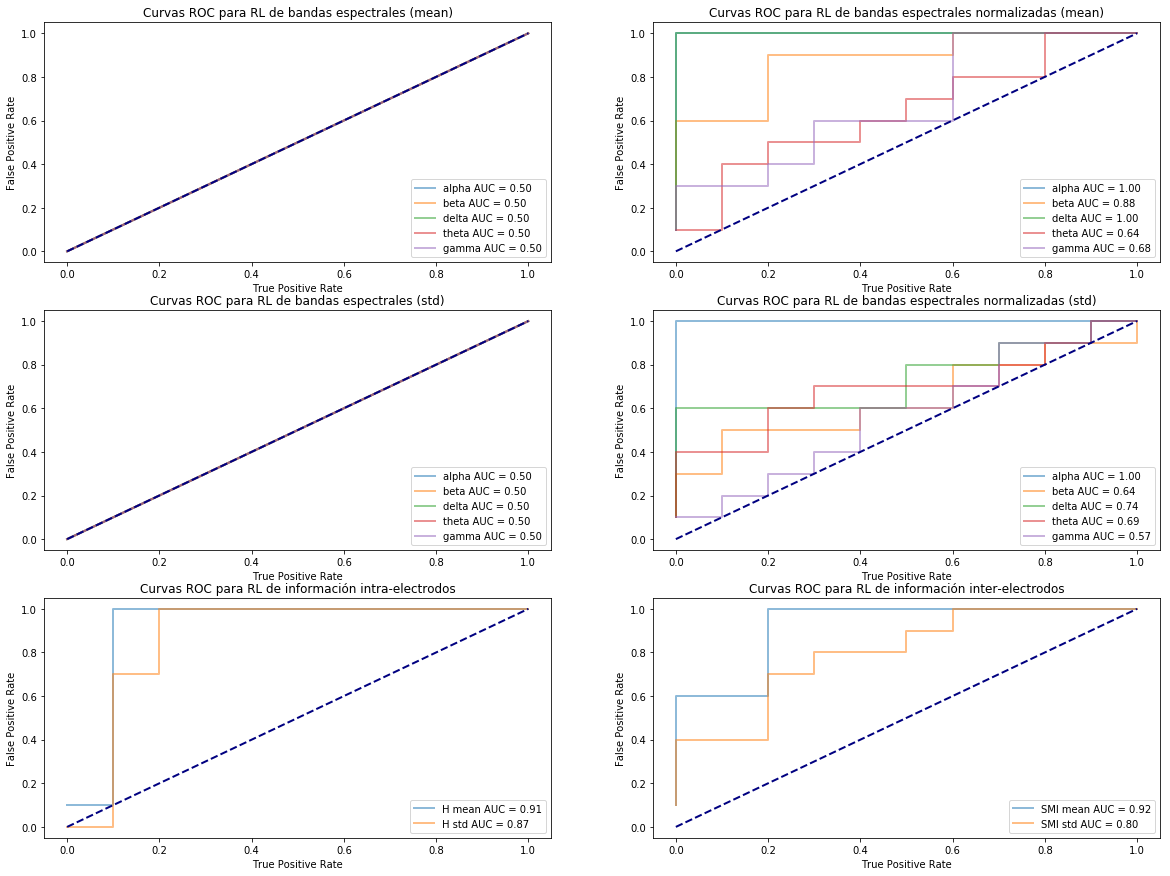

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
plot_roc_logisticCV(axs[0][0], 'Curvas ROC para RL de bandas espectrales (mean)',
                 [('alpha', band_mean['alpha'].values),
                  ('beta', band_mean['beta'].values),
                  ('delta', band_mean['delta'].values),
                  ('theta', band_mean['theta'].values),
                  ('gamma', band_mean['gamma'].values),
                 ])

plot_roc_logisticCV(axs[0][1], 'Curvas ROC para RL de bandas espectrales normalizadas (mean)',
                 [('alpha', band_norm_mean['alpha'].values),
                  ('beta', band_norm_mean['beta'].values),
                  ('delta', band_norm_mean['delta'].values),
                  ('theta', band_norm_mean['theta'].values),
                  ('gamma', band_norm_mean['gamma'].values),
                 ])

plot_roc_logisticCV(axs[1][0], 'Curvas ROC para RL de bandas espectrales (std)',
                 [('alpha', band_std['alpha'].values),
                  ('beta', band_std['beta'].values),
                  ('delta', band_std['delta'].values),
                  ('theta', band_std['theta'].values),
                  ('gamma', band_std['gamma'].values),
                 ])

plot_roc_logisticCV(axs[1][1], 'Curvas ROC para RL de bandas espectrales normalizadas (std)',
                 [('alpha', band_norm_std['alpha'].values),
                  ('beta', band_norm_std['beta'].values),
                  ('delta', band_norm_std['delta'].values),
                  ('theta', band_norm_std['theta'].values),
                  ('gamma', band_norm_std['gamma'].values),
                 ])

plot_roc_logisticCV(axs[2][0], 'Curvas ROC para RL de información intra-electrodos',
                 [('H mean', intra_entropy['mean'].values),
                  ('H std', intra_entropy['std'].values),
                 ])

plot_roc_logisticCV(axs[2][1], 'Curvas ROC para RL de información inter-electrodos',
                 [('SMI mean', inter_entropy['mean'].values),
                  ('SMI std', inter_entropy['std'].values),
                 ])

<p style="text-align: justify;">
Comparando los gráficos de curvas ROC obtenidas a partir de un clasificador del tipo Regresión Logística (RL) se observa, tanto para las medidas de información como para las de las bandas normalizadas, que alcanzan los mismos valores de AUC que en el análisis anterior. 
<br>
Por otro lado, para los atributos que corresponden a las potencias medias y desvíos standard de las bandas espectrales sin normalizar, se encuentra que las mismas disminuyen por completo su capacidad de distinguir entre grupos al punto de tener el mismo desempeño que el azar (AUC = 0.5). Esto puede deberse a que la regresión logística resulta sensible a la normalización de las potencias de las bandas espectrales.
<br>
Según lo encontrado en este análisis, las potencias medias y desvíos standard de las bandas espectrales sin normalizar resultarían ser malos clasificadores.
</p> 

<a name="multivariado"></a>
## 2.2. Análisis Multivariado

<p style="text-align: justify;">
Estudiamos la capacidad de las features de discriminar clases cuando se utilizan en conjunto para determinar umbrales de decisión de clasificadores. Aplicamos SVM para clasificar y exploramos distintas herramientas de esta técnica multivariada de Machine Learning.
</p> 

<p style="text-align: justify;">
Cargamos todos los atributos obtenidos previamente y armamos los vectores de features.
</p> 

In [15]:
band_mean = pd.read_pickle('pickles/band_power_mean.pkl')
band_std = pd.read_pickle('pickles/band_power_std.pkl')
band_norm_mean = pd.read_pickle('pickles/band_power_norm_mean.pkl')
band_norm_std = pd.read_pickle('pickles/band_power_norm_std.pkl')
intra_entropy = pd.read_pickle('pickles/intra_entropy.pkl')
inter_entropy = pd.read_pickle('pickles/inter_entropy.pkl')

In [16]:
etiquetas = np.array(['P'] * 10 + ['S'] * 10)

In [17]:
etiquetas_binarias = np.array([c == 'P' for c in etiquetas])

In [18]:
# Lista de nombres de bandas espectrales
band_names = ['alpha', 'beta', 'gamma', 'delta', 'theta']
# Ordeno para no mezclar columnas
band_mean = band_mean[band_names]
band_std = band_std[band_names]
band_norm_mean = band_norm_mean[band_names]
band_norm_std = band_norm_std[band_names]
# Reemplazo los nombres de las columnas
band_mean.columns = [s + ' mean' for s in band_names]
band_std.columns = [s + ' std' for s in band_names]
band_norm_mean.columns = [s + ' norm mean' for s in band_names]
band_norm_std.columns = [s + ' norm std' for s in band_names]

# Lista de nombres de medidas de información
info_names = ['mean', 'std']
# Ordeno para no mezclar columnas
intra_entropy = intra_entropy[info_names]
inter_entropy = inter_entropy[info_names]
# Reemplazo los nombres de las columnas
intra_entropy.columns = ['H mean', 'H std']
inter_entropy.columns = ['SMI mean', 'SMI std']

In [19]:
features = pd.concat([band_mean,band_std,band_norm_mean,band_norm_std,intra_entropy,inter_entropy], axis=1)
features.columns

Index(['alpha mean', 'beta mean', 'gamma mean', 'delta mean', 'theta mean',
       'alpha std', 'beta std', 'gamma std', 'delta std', 'theta std',
       'alpha norm mean', 'beta norm mean', 'gamma norm mean',
       'delta norm mean', 'theta norm mean', 'alpha norm std', 'beta norm std',
       'gamma norm std', 'delta norm std', 'theta norm std', 'H mean', 'H std',
       'SMI mean', 'SMI std'],
      dtype='object')

<p style="text-align: justify;">
De esta manera, generamos una matriz de features, donde las filas son los samples o sujetos y las columnas son las features o atributos.
</p> 

In [20]:
features.shape

(20, 24)

<p style="text-align: justify;">
Entrenamos entonces un clasificador por Support Vector Machines utilizando todos los features y samples, y obtenemos la curva ROC, la distancia de todos los samples al hiperplano resultante del entrenamiento, y algunas medidas de performance como el 'Accuracy' y el 'F1-score'.
</p> 

In [21]:
def plot_decision(scores, etiquetas_binarias):
    """Plotea los puntos según su etiqueta y distancia al hiperplano de corte"""
    sns.swarmplot(etiquetas_binarias, y_score)
    for y, e in zip(y_score, etiquetas_binarias):
        axhline(y, xmin=-1, xmax=1, color='orange' if e else 'blue', alpha=0.3, lw=1)
    axhline(0, xmin=-1, xmax=1, color='grey', lw=1)
    title('Distancia de los datos al hiperplano de corte')

Score: 0.9


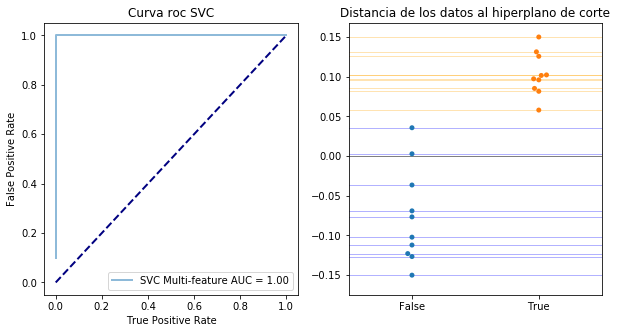

In [22]:
classifier = svm.SVC().fit(features, etiquetas_binarias)
print('Score:', classifier.score(features, etiquetas_binarias))
y_score = classifier.decision_function(features)
fpr, tpr, tps = metrics.roc_curve(etiquetas_binarias, y_score)
auc = metrics.roc_auc_score(etiquetas_binarias, y_score)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_rocs(axs[0], 'Curva roc SVC', [('SVC Multi-feature', fpr, tpr, auc)])
sca(axs[1])
plot_decision(y_score, etiquetas_binarias)

In [23]:
y_pred = classifier.predict(features)      
pd.Series({
    'Accuracy': metrics.accuracy_score(etiquetas_binarias, y_pred),
    'F1': metrics.f1_score(etiquetas_binarias, y_pred)
})

Accuracy    0.900000
F1          0.909091
dtype: float64

<p style="text-align: justify;">
Se observa que la performance del clasificador es significativamente mayor a la que daría el azar para muestras apareadas (0.5). Esto no necesariamente significa que el clasificador sea bueno, ya que como se utilizaron todos los samples y no se aplicó una validación cruzada, probablemente ajuste muy bien para estos datos pero no sea bueno para generalizar a otros datos. Sin embargo, que la performance sea buena indica que los samples utilizados muestran diferencias entre clases apreciables desde las features obtenidas del análisis de frecuencia y de información.
</p> 

### Matriz de confusión

<p style="text-align: justify;">
Otra forma de evaluar la performance del clasificador es a partir de la matriz de confusión, en la cual se comparan las etiquetas predichas con las reales de los datos.
</p> 

In [24]:
metrics.confusion_matrix(etiquetas_binarias, y_pred)

array([[ 8,  2],
       [ 0, 10]], dtype=int64)

<p style="text-align: justify;">
Definimos una función para graficar la matriz de confusión.
</p> 

In [25]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')
#    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<p style="text-align: justify;">
Graficamos la matriz de confusión sin normalizar. En el eje *y* se muestran las etiquetas reales de los samples, y en el eje *x* las etiquetas predichas por el clasificador. De esta manera, los elementos diagonales contienen la cantidad de samples de cada etiqueta que fueron clasificados correctamente por el clasificador. Los elementos no diagonales contienen los samples mal clasificados.
</p> 

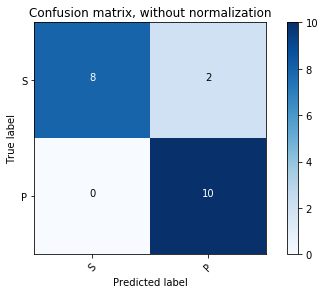

In [26]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(metrics.confusion_matrix(etiquetas_binarias, y_pred), classes=['S','P'],
                      title='Confusion matrix, without normalization')


<p style="text-align: justify;">
En general resulta conveniente graficar la matriz de correlación normalizada, dividiendo todos los samples que pertenecen a la misma categoría por el número total de samples de esa categoría (es decir, a cada elemento de una determinada fila lo divido por la suma total de la fila). En este caso no sería necesario ya que las categorías se encuentran balanceadas y resulta sencillo evaluar la performance del clasificador a partir de la matriz de confusión. Sin embargo, graficamos la matriz de confusión normalizada para complementar el análisis.
</p> 

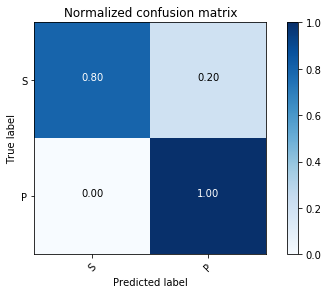

In [27]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(metrics.confusion_matrix(etiquetas_binarias, y_pred), classes=['S','P'],normalize=True,
                      title='Normalized confusion matrix')
plt.show()

<p style="text-align: justify;">
Se observa entonces, que el clasificador etiqueta correctamente a todos los sujetos del grupo *P*, pero que etiqueta incorrectamente a 2 sujetos del grupo *S*, que representa el 20% de los samples de esa categoría. Esto también se observa en las etiquetas predichas ya que deberían ser *P* para los 1eros 10 samples y *S* para los últimos 10, pero el clasificador predice dos etiquetas incorrectamente.
</p> 

In [28]:
y_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False,  True], dtype=bool)

### Probabilidad

<p style="text-align: justify;">
Para calcular la probabilidad predicha por el clasificador de que cada sample pertenezca a una cierta clase, tiene que estar el parámetro 'probability' del clasificador seteado en *True*. Exploramos las diferencias de setearlo de esta manera.
</p> 

In [29]:
clf = svm.SVC(probability=True)
clf.fit(features, etiquetas)
y_score = clf.decision_function(features)

In [30]:
clf.predict_proba(features)

array([[ 0.48931811,  0.51068189],
       [ 0.48597077,  0.51402923],
       [ 0.47785481,  0.52214519],
       [ 0.48585775,  0.51414225],
       [ 0.48870838,  0.51129162],
       [ 0.48192656,  0.51807344],
       [ 0.48690217,  0.51309783],
       [ 0.48668589,  0.51331411],
       [ 0.49328187,  0.50671813],
       [ 0.48098547,  0.51901453],
       [ 0.5       ,  0.5       ],
       [ 0.52812937,  0.47187063],
       [ 0.52178493,  0.47821507],
       [ 0.5235869 ,  0.4764131 ],
       [ 0.51457156,  0.48542844],
       [ 0.51584962,  0.48415038],
       [ 0.52012563,  0.47987437],
       [ 0.52421059,  0.47578941],
       [ 0.50911522,  0.49088478],
       [ 0.5       ,  0.5       ]])

<p style="text-align: justify;">
Obtuvimos los valores de distancia al umbral de decisión.
</p> 

In [31]:
clf.decision_function(features)

array([-0.08171378, -0.10170976, -0.15021979, -0.10238501, -0.08535571,
       -0.12587699, -0.09614527, -0.09743739, -0.05804178, -0.13150223,
       -0.00285846,  0.15021976,  0.11222787,  0.12301236,  0.06909527,
        0.07673369,  0.102301  ,  0.12674609,  0.03649832, -0.03574834])

<p style="text-align: justify;">
Y comparamos con los valores obtenidos sin setear el parámetro.
</p> 

In [32]:
classifier.decision_function(features)

array([ 0.08171378,  0.10170976,  0.15021979,  0.10238501,  0.08535571,
        0.12587699,  0.09614527,  0.09743739,  0.05804178,  0.13150223,
        0.00285846, -0.15021976, -0.11222787, -0.12301236, -0.06909527,
       -0.07673369, -0.102301  , -0.12674609, -0.03649832,  0.03574834])

<p style="text-align: justify;">
Las distancias obtenidas son las mismas (a diferencia del signo que es arbitrario) por lo que, en principio, el clasificador no cambia al setearlo así. Pero probablemente cambien los tiempos de cómputo debido a que usa el método de Platt para el cálculo de probabilidades.
</p> 

### Multi Dimensional Scaling

<p style="text-align: justify;">
Para plotear los datos se puede usar un embedding y pasar de las 24 dimensiones de las features a representar cada sample con 2 dimensiones de manera de poder graficarlos. Esto se puede hacer usando el comando MDS.
</p> 

In [33]:
mds = manifold.MDS()
y_mds = mds.fit_transform(features)

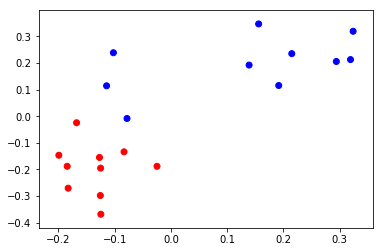

In [34]:
colors = np.array(['red'] * 10 + ['blue'] * 10)
plt.figure()
pyplot.scatter(y_mds[:,0], y_mds[:,1],c=colors)
plt.show()

### Vectores Soporte

<p style="text-align: justify;">
Se puede entrenar el clasificador usando solo 2 dimensiones del espacio de features. Esto hace que los samples se puedan representar en un espacio de features bidimensional, y por lo tanto sea posible graficarlos en un plot. En este gráfico se puede visualizar el método de SVM y los vectores soporte que utiliza para separar las clases. Para una mejor visualización, utilizamos un kernel lineal y elegimos el parámetro de regularización arbitrariamente alto.
</p> 

<p style="text-align: justify;">
Como ejemplo, usamos los features obtenidos del análisis de frecuencias que mejor capacidad de clasificación mostraban en el caso univariado. Seleccionamos, entonces, los valores de potencia espectral normalizada promedio y su fluctuación.
</p> 

In [35]:
x = features.iloc[:,[10,15]]

In [36]:
classifier = svm.SVC(kernel='linear', C=1000)
classifier.fit(x, etiquetas_binarias)
y_score = classifier.decision_function(x)

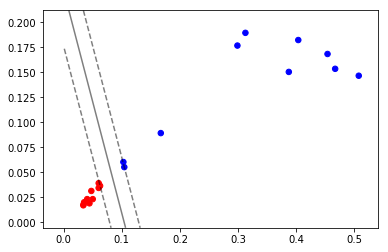

In [37]:
colors = np.array(['red'] * 10 + ['blue'] * 10)

plt.scatter(x.iloc[:, 0], x.iloc[:, 1], c=colors, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = classifier.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none')
plt.show()

<p style="text-align: justify;">
También utilizamos como ejemplo los atributos obtenidos de la transformación de embedding obtenida a partir del Multi Dimensional Scaling.
</p> 

In [38]:
x = pd.DataFrame([y_mds[:,0], y_mds[:,1]]).T

In [39]:
classifier = svm.SVC(kernel='linear', C=1000)
classifier.fit(x, etiquetas_binarias)
y_score = classifier.decision_function(x)

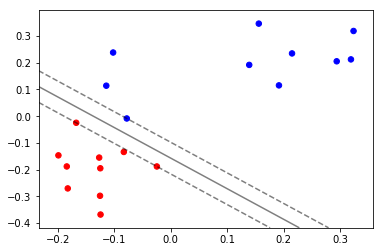

In [40]:
colors = np.array(['red'] * 10 + ['blue'] * 10)

plt.scatter(x.iloc[:, 0], x.iloc[:, 1], c=colors, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = classifier.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none')
plt.show()

<p style="text-align: justify;">
En ambos casos, se visualizan las distintas clases con distintos colores. Cada punto es un sample en el espacio bidimensional de features utilizados. La línea sólida muestra el umbral de decisión obtenido del entrenamiento del SVM con kernel lineal para todos los samples y sin regularización. Y las líneas punteadas muestran los vectores soporte que marginalizan la distancia de los puntos a dicho umbral.
</p>

### Regularización con SGD

<p style="text-align: justify;">
También puedo entrenar un clasificador por SVM con kernel lineal, pero usando SGD (Stochastic Gradient Descent) para aplicar regularización al modelo. Esto puede ayudar a disminuir el overfitting y mejorar la performance en el caso en el que separamos en subsets de entrenamiento y testeo.
</p> 

In [50]:
clf = linear_model.SGDClassifier()
clf.fit(features, etiquetas_binarias)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [51]:
clf.score(features, etiquetas_binarias)  

0.94999999999999996

In [52]:
clf.predict(features)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True], dtype=bool)

In [53]:
clf.decision_function(features)

array([  4.98300192,   6.85982458,  11.4117536 ,   7.32643277,
         5.20149119,   9.48200675,   6.13972558,   6.66005533,
         2.85404053,   9.5833008 ,  -1.86570339, -11.01810946,
        -7.99654565,  -8.97986224,  -5.53307812,  -6.25016283,
        -7.81527566, -10.41464543,  -4.84512623,   1.2846094 ])

<p style="text-align: justify;">
Resulta interesante notar que en muchos casos el SGD no converge o converge a distintos mínimos locales de la función costo debido a que el método hace una aproximación estocástica para resolver el problema de optimización del gradiente de descenso, por lo que el modelo puede dar diferente y su score valores distintos.
</p> 

In [54]:
scores_sgd = np.zeros((100,1))
for i in range(100):
    clf = linear_model.SGDClassifier()
    clf.fit(features, etiquetas_binarias)
    scores_sgd[i] = clf.score(features, etiquetas_binarias)  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


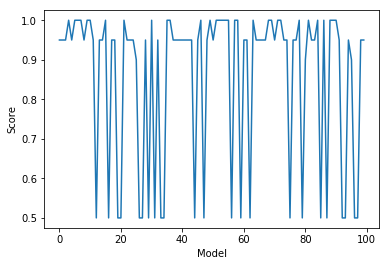

In [55]:
plt.figure()
plot(scores_sgd)
plt.ylabel('Score')
plt.xlabel('Model')
plt.show()

###  Con separación train-test

<p style="text-align: justify;">
Para evitar el sobreajuste de los datos, de manera tal que el clasificador pueda generalizarse a nuevos samples, resulta necesario entrenar con un subset de datos de entrenamiento y evaluar el clasificador en otro subset de testeo independiente.
</p> 

<p style="text-align: justify;">
Separo en subsets de entrenamiento y testeo
</p> 

In [56]:
X_train, X_test, y_train, y_test = train_test_split(features, etiquetas_binarias, test_size=0.2, random_state=0)

<p style="text-align: justify;">
Entreno el clasificador usando SVM
</p> 

In [57]:
classifier = svm.SVC().fit(X_train, y_train)

<p style="text-align: justify;">
Evalúo el clasificador en el subset de testeo
</p> 

In [58]:
y_pred = classifier.predict(X_test)      
pd.Series({
    'Accuracy': metrics.accuracy_score(y_test, y_pred),
    'F1': metrics.f1_score(y_test, y_pred)
})

Accuracy    0.75
F1          0.80
dtype: float64

In [59]:
y_score = classifier.decision_function(X_test)

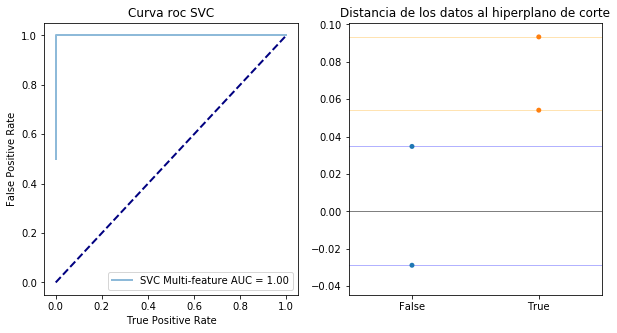

In [60]:
fpr, tpr, tps = metrics.roc_curve(y_test, y_score)
auc = metrics.roc_auc_score(y_test, y_score)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_rocs(axs[0], 'Curva roc SVC', [('SVC Multi-feature', fpr, tpr, auc)])
sca(axs[1])
plot_decision(y_score, y_test)

### Cross-Validation

<p style="text-align: justify;">
Exploramos aplicar una validación cruzada.
</p> 

In [61]:
scoring = ['accuracy', 'f1']
cv = KFold(n_splits=5, shuffle=True)
splits = cv.split(features, etiquetas_binarias)
scores = pd.DataFrame(columns=['F1', 'Accuracy'])
for train_idxs, test_idxs in splits:
    classifier = svm.SVC()
    classifier.fit(features.iloc[train_idxs], etiquetas_binarias[train_idxs])
    y_test = etiquetas_binarias[test_idxs]
    y_pred = classifier.predict(features.iloc[test_idxs])
    scores = scores.append(pd.Series({
        'F1': metrics.f1_score(y_test, y_pred),
        'Accuracy': metrics.accuracy_score(y_test, y_pred)
    }), ignore_index=True)
scores.append(pd.Series(scores.mean(), name='Mean')).T

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,0,1,2,3,4,Mean
F1,0.00,0.80,0.40,0.00,0.40,0.32
Accuracy,0.25,0.75,0.25,0.25,0.25,0.35


### Curva de Aprendizaje

<p style="text-align: justify;">
Calculamos la curva de aprendizaje a partir del score de entrenamiento y CV para distinto número de samples. Para este caso, utilizamos un clasificador de Naive Bayes en lugar del SVM porque con el SVM el comando 'learning_curves' de 'scikit learn' presentaba problemas ya que no siempre aparecían samples de ambas clases luego de la separación en subsets.
</p> 

In [62]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

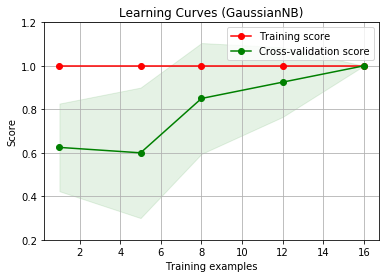

In [63]:
title = "Learning Curves (GaussianNB)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = model_selection.ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
model_selection.StratifiedShuffleSplit() 
estimator =  naive_bayes.GaussianNB()#svm.SVC(gamma=0.001)
plot_learning_curve(estimator, title, features, etiquetas_binarias, (0.2, 1.2), cv=cv, n_jobs=5)

plt.show()

<p style="text-align: justify;">
Se observa que el problema no es sesgado ya que el score de entrenamiento es siempre alto, y que tampoco presenta gran varianza cuando se utilizan la mayoría de los samples ya que el score de CV tiende a parecerse al de entrenamiento para números de samples altos. Esto permitiría pensar que los datos pueden llegar a ser suficientes para que no sea un gran inconveniente el *overfitting*.
</p> 

### Pipeline

<p style="text-align: justify;">
Utilizamos la herramienta de *scikit learn* que permite definir pipelines para aplicar una lista secuencial de comandos para el entrenamiento del clasificador. Definimos los siguientes pasos para la clasificación:
    <li> Standard Scaler. </li>
    <li> Feature Selection utilizando solo el 10%. </li>
    <li> SVC. </li>
</p> 


In [64]:
pipe = pipeline.Pipeline([('scale', preprocessing.StandardScaler()),
                          ('feature_selection', feature_selection.SelectPercentile(percentile=10)),
                          ('clf', svm.SVC())])

In [65]:
cv = model_selection.cross_validate(pipe, features, etiquetas_binarias, 
                                    cv=model_selection.KFold(n_splits=5), 
                                    scoring=['f1', 'accuracy'])
df = pd.DataFrame({'f1': cv['test_f1'], 'accuracy': cv['test_accuracy']})
df = df.append(pd.Series(df.mean(), name='Mean'))
df.T

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


,0,1,2,3,4,Mean
accuracy,1.0,1.0,0.75,1.0,0.75,0.90
f1,1.0,1.0,0.80,0.0,0.00,0.56


#### Variamos la cantidad de features elegidos en 10, 20 y 35%

In [66]:
search = model_selection.GridSearchCV(
    estimator=pipe, 
    param_grid={'feature_selection__percentile': [10, 20, 35]},
    scoring=['f1', 'accuracy'],
    cv=KFold(n_splits=5, shuffle=True),
    refit=False)

In [67]:
res = search.fit(features, etiquetas_binarias)

In [68]:
f1_result_names = ['split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1']
f1_results = [res.cv_results_[k] for k in f1_result_names]
df = pd.DataFrame(f1_results, index=range(5), columns=['10%', '20%', '35%'])
df = df.append(pd.Series(df.mean(),  name='Mean'))
print('**F1 scores para distintos porcentajes de features**')
print('Columnas son los splits del CV')
print('Filas es el porcentaje de features utilizados')
df

**F1 scores para distintos porcentajes de features**
Columnas son los splits del CV
Filas es el porcentaje de features utilizados


,10%,20%,35%
0,0.80,0.80,1.00
1,0.80,0.80,0.80
2,0.80,0.80,0.80
3,1.00,1.00,1.00
4,1.00,1.00,1.00
Mean,0.88,0.88,0.92


In [69]:
acc_result_names = ['split0_test_accuracy', 'split1_test_accuracy', 
                    'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy']
acc_results = [res.cv_results_[k] for k in acc_result_names]
df = pd.DataFrame(acc_results, index=range(5), columns=['10%', '20%', '35%'])
df = df.append(pd.Series(df.mean(),  name='Mean'))
print('**Accuracy scores para distintos porcentajes de features**')
print('Columnas son los splits del CV')
print('Filas es el porcentaje de features utilizados')
df

**Accuracy scores para distintos porcentajes de features**
Columnas son los splits del CV
Filas es el porcentaje de features utilizados


,10%,20%,35%
0,0.75,0.75,1.00
1,0.75,0.75,0.75
2,0.75,0.75,0.75
3,1.00,1.00,1.00
4,1.00,1.00,1.00
Mean,0.85,0.85,0.90
